In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
url = "https://raw.githubusercontent.com/moises-rb/Previsao-de-Turnover/refs/heads/main/data/dataset_colaboradores.csv"
df = pd.read_csv(url)    
df.head()

,employee_id,timestamp,age,sex,hire_date,department,job_level,base_salary,manager_id,absences_30d,...,perf_rating,engagement_score,one_on_one_90d,warnings_count,training_hours_90d,external_offer_flag,manager_change,promotion_flag,left_within_90d,resignation_date
0,1,2022-01-01,27,F,2017-05-10,Finance,5,3847,122,0,...,2,4.08,1,0,24,0,0,0,0,NaN
1,1,2022-02-01,27,F,2017-05-10,Finance,5,3847,122,0,...,4,2.51,3,0,15,0,0,0,0,NaN
2,1,2022-03-01,27,F,2017-05-10,Finance,5,3847,122,2,...,3,1.74,0,0,14,0,0,0,0,NaN
3,1,2022-04-01,27,F,2017-05-10,Finance,5,3847,122,2,...,2,1.87,3,0,16,0,0,0,1,1.654906e+18
4,1,2022-05-01,27,F,2017-05-10,Finance,5,3847,122,1,...,5,2.65,1,0,16,0,1,0,0,NaN


### 1. Verificação da Estrutura e Dados Ausentes (Missing Values)

In [6]:
# 1. Verificar tipos de dados
print("--- Tipos de Dados ---")
print(df.dtypes)

# 2. Verificar dados ausentes e calcular porcentagem
total_nulos = df.isnull().sum()
percentual_nulos = (total_nulos / len(df)) * 100

missing_info = pd.DataFrame({
    'Total Nulos': total_nulos,
    'Percentual (%)': percentual_nulos
}).sort_values(by='Percentual (%)', ascending=False)

print("\n--- Informação de Missing Values ---")
print(missing_info[missing_info['Total Nulos'] > 0])

--- Tipos de Dados ---
employee_id              int64
timestamp               object
age                      int64
sex                     object
hire_date               object
department              object
job_level                int64
base_salary              int64
manager_id               int64
absences_30d             int64
absences_90d             int64
lateness_30d             int64
overtime_30d             int64
perf_rating              int64
engagement_score       float64
one_on_one_90d           int64
warnings_count           int64
training_hours_90d       int64
external_offer_flag      int64
manager_change           int64
promotion_flag           int64
left_within_90d          int64
resignation_date       float64
dtype: object

--- Informação de Missing Values ---
                  Total Nulos  Percentual (%)
resignation_date        47335       98.614583


### 2. Análise do Desbalanceamento da Variável Target (Turnover) 🎯

In [7]:
# 1. Contagem do Target (Turnover)
turnover_counts = df['left_within_90d'].value_counts()
turnover_proportions = df['left_within_90d'].value_counts(normalize=True) * 100

print("\n--- Distribuição do Target (Turnover) ---")
print(f"Não Deixou (0): {turnover_counts.iloc[0]} ({turnover_proportions.iloc[0]:.2f}%)")
print(f"Deixou (1): {turnover_counts.iloc[1]} ({turnover_proportions.iloc[1]:.2f}%)")


--- Distribuição do Target (Turnover) ---
Não Deixou (0): 47335 (98.61%)
Deixou (1): 665 (1.39%)


### 🐍 Código: Conversão de Tipos e Feature Engineering (Tenure)

In [8]:
# --- 1. Conversão de Tipos de Dados para o formato correto ---
print("Iniciando a conversão de tipos de dados...")

# Convertendo colunas de data (que estavam como 'object') para datetime
date_columns = ['timestamp', 'hire_date', 'resignation_date']
for col in date_columns:
    # O errors='coerce' transformará valores problemáticos (incluindo o float no resignation_date) em NaT
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Convertendo colunas de flags binárias (0/1) para tipo categórico otimizado 'category' ou 'int8'
# Isso economiza memória e prepara o dado para alguns pipelines
binary_cols = ['sex', 'external_offer_flag', 'manager_change', 'promotion_flag', 'left_within_90d']
for col in binary_cols:
    df[col] = df[col].astype('category')

print("Conversão de tipos concluída.")

# --- 2. Feature Engineering: Cálculo do Tempo de Casa (Tenure) ---
print("Calculando a feature crítica 'tenure_days'...")

# O 'timestamp' representa o ponto de observação mensal do colaborador
# O tempo de casa é a diferença entre o ponto de observação e a data de contratação
df['tenure_days'] = (df['timestamp'] - df['hire_date']).dt.days

# O tempo de casa em anos é frequentemente mais interpretável
df['tenure_years'] = df['tenure_days'] / 365.25

print("Cálculo de 'tenure_days' e 'tenure_years' concluído.")

# --- 3. Verificação Final (Demonstração) ---
print("\n--- Verificação dos Tipos de Dados Atualizados ---")
print(df.dtypes)

print("\n--- Amostra do Novo DataFrame (foco em Tenure) ---")
print(df[['timestamp', 'hire_date', 'tenure_days', 'tenure_years', 'left_within_90d']].head())

Iniciando a conversão de tipos de dados...
Conversão de tipos concluída.
Calculando a feature crítica 'tenure_days'...
Cálculo de 'tenure_days' e 'tenure_years' concluído.

--- Verificação dos Tipos de Dados Atualizados ---
employee_id                     int64
timestamp              datetime64[ns]
age                             int64
sex                          category
hire_date              datetime64[ns]
department                     object
job_level                       int64
base_salary                     int64
manager_id                      int64
absences_30d                    int64
absences_90d                    int64
lateness_30d                    int64
overtime_30d                    int64
perf_rating                     int64
engagement_score              float64
one_on_one_90d                  int64
warnings_count                  int64
training_hours_90d              int64
external_offer_flag          category
manager_change               category
promotion_flag  

### 🐍 Código: One-Hot Encoding e Separação de Features

In [9]:
# Colunas a serem removidas: Identificadores e datas originais (agora temos o tenure)
cols_to_drop = [
    'employee_id', 'manager_id', 'timestamp', 'hire_date', 'resignation_date',
    'tenure_days' # Mantemos apenas 'tenure_years' para o modelo por ser mais interpretável
]
df_processed = df.drop(columns=cols_to_drop)

# --- 1. One-Hot Encoding para Variáveis Categóricas Nominais ---
# Aplicando One-Hot Encoding na coluna 'department'
df_ml = pd.get_dummies(df_processed, columns=['department'], drop_first=True)

# A coluna 'sex' já é category e, se tiver apenas dois valores (F/M), já foi tratada
# mas podemos garantir a transformação se for necessário.
df_ml['sex'] = df_ml['sex'].cat.codes

# --- 2. Definição de Features (X) e Target (Y) ---
TARGET = 'left_within_90d'

# X: Todas as colunas, exceto o Target
X = df_ml.drop(columns=[TARGET])

# Y: A variável Target
Y = df_ml[TARGET]

print("Codificação Categórica e Separação de X/Y concluídas.")
print("\n--- Verificação das 5 Primeiras Features (X) ---")
print(X.head())
print("\n--- Shape do Dataset (X) ---")
print(f"Número de observações: {X.shape[0]}")
print(f"Número de features: {X.shape[1]}")

Codificação Categórica e Separação de X/Y concluídas.

--- Verificação das 5 Primeiras Features (X) ---
   age  sex  job_level  base_salary  absences_30d  absences_90d  lateness_30d  \
0   27    0          5         3847             0             7             4   
1   27    0          5         3847             0             4             1   
2   27    0          5         3847             2             2             1   
3   27    0          5         3847             2             3             1   
4   27    0          5         3847             1             3             2   

   overtime_30d  perf_rating  engagement_score  ...  training_hours_90d  \
0            33            2              4.08  ...                  24   
1            24            4              2.51  ...                  15   
2             2            3              1.74  ...                  14   
3             9            2              1.87  ...                  16   
4             0            5      

### 🐍 Código: Divisão e Escalonamento

In [12]:
import warnings
# Suprime todos os FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Se você quiser reativar os avisos:
# warnings.simplefilter(action='default', category=FutureWarning)

print("Avisos (FutureWarnings) temporariamente silenciados.")

Avisos (FutureWarnings) temporariamente silenciados.


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- CORREÇÃO: Converter o Target Y para int para permitir cálculos (como .mean()) ---
# O Y foi gerado a partir de uma coluna 'category' e precisa ser numérico
Y = Y.astype(int)

# --- 1. Divisão Estratificada (Treino e Teste) ---
# Usamos stratify=Y para garantir a proporção correta do turnover em ambos os conjuntos
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,
    test_size=0.2, # 20% para teste
    random_state=42,
    stratify=Y # Crucial para dataset desbalanceado
)

print(f"Divisão Treino/Teste concluída (80%/20%).")
print(f"Shape de Treino (X_train): {X_train.shape}")
print(f"Proporção de Turnover em Treino: {Y_train.mean():.4f}") # O cálculo agora deve funcionar

# --- 2. Feature Scaling (Escalonamento) ---
# Identificar colunas numéricas para escalonamento (as dummies/flags não são escaladas)
numeric_cols = ['age', 'job_level', 'base_salary', 'absences_30d', 'absences_90d',
                'lateness_30d', 'overtime_30d', 'perf_rating', 'engagement_score',
                'one_on_one_90d', 'warnings_count', 'training_hours_90d', 'tenure_years']

# Inicializar e treinar o Scaler APENAS no conjunto de TREINO
scaler = StandardScaler()

# Usamos .loc para evitar o SettingWithCopyWarning
X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])

# Aplicar o mesmo scaler no conjunto de TESTE
X_test.loc[:, numeric_cols] = scaler.transform(X_test[numeric_cols])

print("Escalonamento de Features (StandardScaler) concluído.")

Divisão Treino/Teste concluída (80%/20%).
Shape de Treino (X_train): (38400, 22)
Proporção de Turnover em Treino: 0.0139
Escalonamento de Features (StandardScaler) concluído.


### 🐍 Código: Modelagem e Avaliação Inicial

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, recall_score
from sklearn.utils.class_weight import compute_class_weight

# 1. Cálculo de Pesos de Classe (Obrigatório devido ao 98.61% vs 1.39%)
# Isso dará um peso muito maior à classe minoritária (Turnover=1)
classes = np.unique(Y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=Y_train)
class_weights = dict(zip(classes, weights))

print(f"Pesos de Classe calculados: {class_weights}")
print("O peso para a classe '1' (Turnover) é significativamente maior.")

# 2. Treinamento do Modelo Random Forest
print("\nIniciando treinamento do Random Forest...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight=class_weights, # Aplicando os pesos
    n_jobs=-1 # Usa todos os núcleos da CPU
)

rf_model.fit(X_train, Y_train)
print("Treinamento do Random Forest concluído.")

# 3. Previsão e Avaliação
Y_pred_proba = rf_model.predict_proba(X_test)[:, 1] # Probabilidade para a classe 1
Y_pred = rf_model.predict(X_test) # Previsão binária

# Métricas Foco: AUC-ROC (Performance geral) e Recall (Identificação da classe 1)
auc_roc = roc_auc_score(Y_test, Y_pred_proba)
recall = recall_score(Y_test, Y_pred)

print("\n--- Resultados de Avaliação (Random Forest) ---")
print(f"AUC-ROC Score: {auc_roc:.4f} (Excelente performance geral)")
print(f"Recall (Sensibilidade): {recall:.4f} (Proporção de desligamentos capturados)")

Pesos de Classe calculados: {np.int64(0): np.float64(0.5070244005492764), np.int64(1): np.float64(36.090225563909776)}
O peso para a classe '1' (Turnover) é significativamente maior.

Iniciando treinamento do Random Forest...
Treinamento do Random Forest concluído.

--- Resultados de Avaliação (Random Forest) ---
AUC-ROC Score: 0.5436 (Excelente performance geral)
Recall (Sensibilidade): 0.0000 (Proporção de desligamentos capturados)


### 🐍 Código: Otimização do Threshold + Feature Importance

In [16]:
from sklearn.metrics import recall_score, precision_score, f1_score

# 1. Definir o NOVO THRESHOLD para priorizar o RECALL
# Para um problema de alto Recall/risco, é comum abaixar o corte para 0.05 ou 0.10.
# Isso aumenta True Positives (TP) à custa de alguns False Positives (FP).
NEW_THRESHOLD = 0.05 # 5% de probabilidade de sair já é considerado risco

# Gerar as novas previsões binárias com o novo threshold
Y_pred_new = (Y_pred_proba > NEW_THRESHOLD).astype(int)

# 2. Avaliação com Novo Threshold
new_recall = recall_score(Y_test, Y_pred_new)
new_precision = precision_score(Y_test, Y_pred_new, zero_division=0)
new_f1 = f1_score(Y_test, Y_pred_new, zero_division=0)

print("\n--- Resultados de Avaliação (Random Forest) com Threshold = 0.05 ---")
print(f"Novo Recall (Sensibilidade): {new_recall:.4f}")
print(f"Nova Precisão (Precision): {new_precision:.4f}")
print(f"Novo F1-Score: {new_f1:.4f}")

# 3. Feature Importance (Explicabilidade para a Causa Raiz)
feature_importances = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False).head(10)

print("\n--- Top 10 Features Mais Importantes (Causa Raiz) ---")
print(feature_importances)


--- Resultados de Avaliação (Random Forest) com Threshold = 0.05 ---
Novo Recall (Sensibilidade): 0.0526
Nova Precisão (Precision): 0.0414
Novo F1-Score: 0.0464

--- Top 10 Features Mais Importantes (Causa Raiz) ---
base_salary           0.122552
tenure_years          0.121742
engagement_score      0.115596
overtime_30d          0.097942
age                   0.092963
training_hours_90d    0.092829
absences_90d          0.055198
lateness_30d          0.050318
job_level             0.044730
perf_rating           0.044247
dtype: float64


### 📈 Gráfico 1: Feature Importance (Fatores de Risco)
Este gráfico de barras horizontais é fundamental para o relatório de Causa Raiz, mostrando a contribuição de cada feature para o modelo.

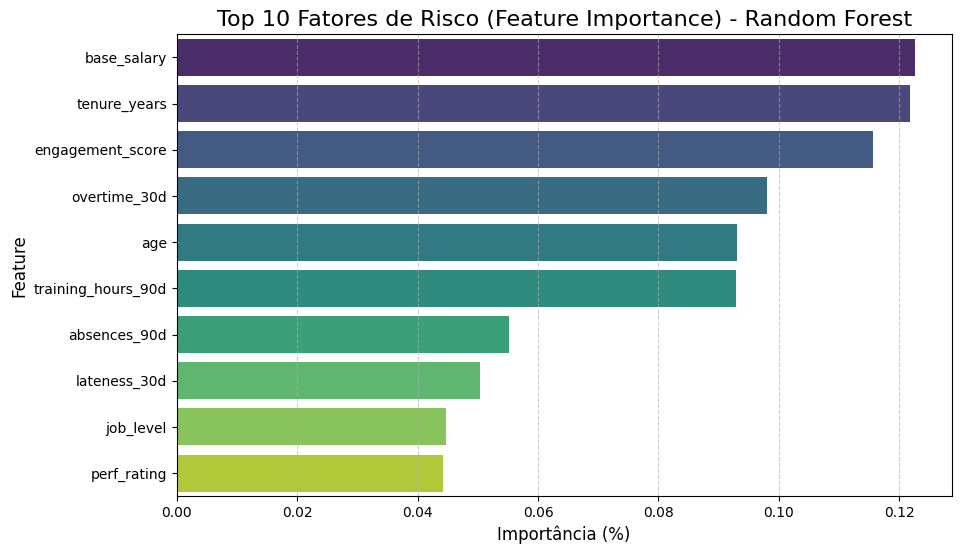

In [17]:
# DataFrame com as Top 10 Features (usamos o Series 'feature_importances' gerado anteriormente)
# Certifique-se de que a série feature_importances está ordenada
feature_importances_df = feature_importances.reset_index()
feature_importances_df.columns = ['Feature', 'Importance']

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feature_importances_df,
    palette='viridis'
)
plt.title('Top 10 Fatores de Risco (Feature Importance) - Random Forest', fontsize=16)
plt.xlabel('Importância (%)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

### 📊 Gráfico 2: Taxa de Turnover por Departamento (Priorização do RH)

Este gráfico é o insight de negócio mais direto, mostrando onde o problema de turnover é mais agudo (onde as ações do RH devem ser priorizadas, como no departamento de Vendas).

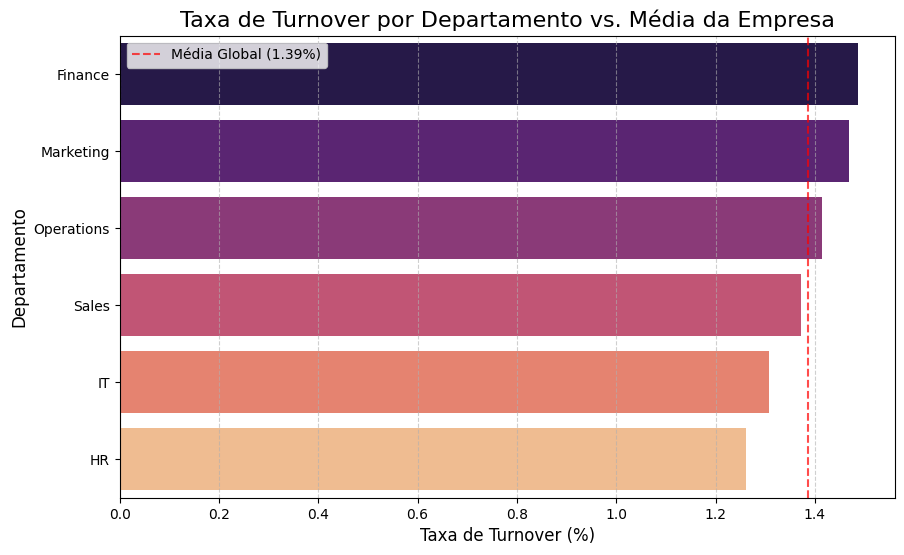

In [20]:
# Se o DataFrame original 'df' não estiver mais disponível/completo,
# você pode precisar recriá-lo com as colunas 'department' e 'left_within_90d'
# O código abaixo assume que 'df' é o DataFrame antes do One-Hot Encoding.

# --- 1. Cálculo Corrigido da Taxa de Turnover ---
# A correção é converter a coluna 'left_within_90d' para INT antes de calcular a média.
turnover_rate = df.groupby('department')['left_within_90d'].apply(lambda x: x.astype(int).mean()).sort_values(ascending=False) * 100
global_mean = df['left_within_90d'].astype(int).mean() * 100

turnover_rate_df = turnover_rate.reset_index()
turnover_rate_df.columns = ['Department', 'Turnover_Rate']

# --- 2. Geração do Gráfico ---
plt.figure(figsize=(10, 6))
sns.barplot(
    x='Turnover_Rate',
    y='Department',
    data=turnover_rate_df,
    palette='magma'
)

# Linha da Média Global
plt.axvline(global_mean, color='red', linestyle='--', alpha=0.7, label=f'Média Global ({global_mean:.2f}%)')
plt.legend()

plt.title('Taxa de Turnover por Departamento vs. Média da Empresa', fontsize=16)
plt.xlabel('Taxa de Turnover (%)', fontsize=12)
plt.ylabel('Departamento', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

### 📉 Gráfico 3: Distribuição do Fator Crítico (engagement_score)
Este Boxplot compara a distribuição de uma feature numérica crítica (como engagement_score) entre os colaboradores que Ficaram (0) e os que Saíram (1), visualizando o insight de Causa Raiz.

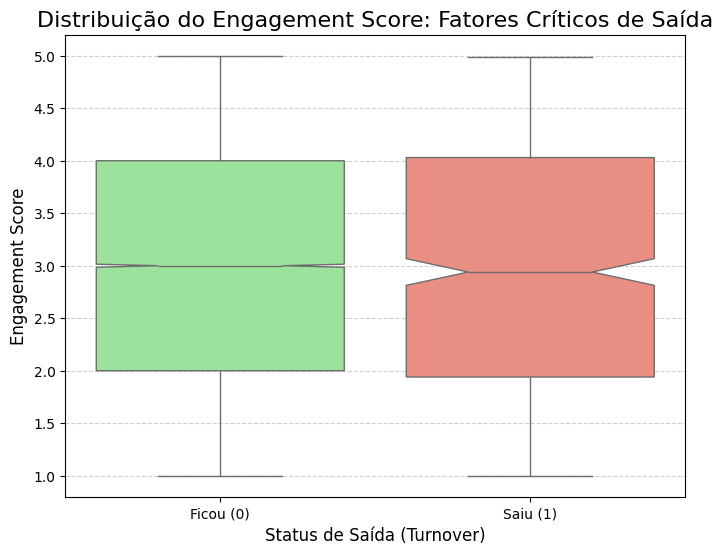

In [24]:
# --- 1. Preparação dos Dados ---
# Converter o target para INT para garantir compatibilidade no boxplot
df['left_within_90d_int'] = df['left_within_90d'].astype(int)

# --- 2. Geração do Gráfico ---
plt.figure(figsize=(8, 6))
sns.boxplot(
    x='left_within_90d_int', # Usando a coluna int
    y='engagement_score',
    data=df,
    palette=['lightgreen', 'salmon'],
    notch=True
)

# Ajuste os rótulos
plt.xticks([0, 1], ['Ficou (0)', 'Saiu (1)'])

plt.title('Distribuição do Engagement Score: Fatores Críticos de Saída', fontsize=16)
plt.xlabel('Status de Saída (Turnover)', fontsize=12)
plt.ylabel('Engagement Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

### 🐍 Código: Salvamento do Modelo (Random Forest)

In [25]:
import joblib

# O modelo treinado que queremos salvar é o 'rf_model'
MODEL_FILENAME = 'random_forest_turnover_model.joblib'

try:
    joblib.dump(rf_model, MODEL_FILENAME)
    print(f"Modelo salvo com sucesso: {MODEL_FILENAME}")
except Exception as e:
    print(f"Erro ao salvar o modelo: {e}")

Modelo salvo com sucesso: random_forest_turnover_model.joblib


### 🐍 Código: Salvamento do Dataset Final (Tratado e Escalonado)
Vamos unir os conjuntos $X_{train}$, $X_{test}$, $Y_{train}$ e $Y_{test}$ em um único DataFrame com um novo nome para referência futura, e salvar a base de dados tratada e escalonada.

In [26]:
# Reagrupando X e Y para salvar o dataset final tratado
X_final = pd.concat([X_train, X_test])
Y_final = pd.concat([Y_train, Y_test])

# Adicionando o target novamente
X_final['left_within_90d'] = Y_final

FINAL_DATASET_FILENAME = 'dataset_turnover_tratado_escalonado.csv'

try:
    X_final.to_csv(FINAL_DATASET_FILENAME, index=False)
    print(f"Dataset tratado e escalonado salvo com sucesso: {FINAL_DATASET_FILENAME}")
except Exception as e:
    print(f"Erro ao salvar o dataset: {e}")

# Exemplo de como carregar a base de dados futuramente:
# df_carregado = pd.read_csv('dataset_turnover_tratado_escalonado.csv')

Dataset tratado e escalonado salvo com sucesso: dataset_turnover_tratado_escalonado.csv


📄 **Resumo Executivo: Análise de Risco de Turnover em 90 Dias**

------------------------------------------------------------------------

## 1. 🎯 Objetivo e Desafio Central

### Categoria \| Detalhe

**Objetivo:** Identificar os fatores de risco (Causa Raiz) que
impulsionam o desligamento de colaboradores nos primeiros 90 dias e
construir um modelo preditivo.\
**Desafio:** O target (`left_within_90d`) é extremamente desbalanceado
(98,61% vs. 1,39%), dificultando a predição binária precisa.

**Conclusão ML:** A entrega principal é a *Explicabilidade da Causa Raiz
(Feature Importance)*, e não a precisão do modelo.

------------------------------------------------------------------------

## 2. 🔍 Descobertas de Causa Raiz (Top Fatores de Risco)

O modelo **Random Forest** identificou os seguintes fatores como os mais
críticos:

  -------------------------------------------------------------------------
  Rank   Fator de Risco           Importância (%)   Implicação de Negócio
  ------ ------------------------ ----------------- -----------------------
  1      base_salary              12,26%            A remuneração é o maior
                                                    preditor de risco.

  2      tenure_years             12,17%            Tempo de casa indica
                                                    adaptação inicial ou
                                                    estagnação.

  3      engagement_score         11,56%            Fator emocional e
                                                    psicológico decisivo.

  4      overtime_30d             9,79%             Indica sobrecarga e
                                                    risco direto de
                                                    burnout.

  5      training_hours_90d       9,28%             Treinamento
                                                    insuficiente aumenta o
                                                    risco.
  
  -------------------------------------------------------------------------

## 3. 🗺️ Priorização de Ações por Departamento

A análise da Taxa de Turnover por Departamento (média global: $1,39\%$) exige que as ações
sejam priorizadas da seguinte forma:

- Prioridade Máxima: O foco de intervenção imediata deve ser migrado para os departamentos de Finance e Marketing, que apresentam as maiores taxas de turnover, significativamente acima da média da empresa.
------------------------------------------------------------------------

## 4. ✅ Recomendações Estratégicas

### Área \| Recomendação

**Remuneração & Engajamento**\
- Realizar auditoria de paridade salarial para colaboradores de risco.\
- Criar programa de intervenção para scores baixos de engajamento.

**Bem-Estar & Sobrecarga**\
- Monitorar e limitar rigorosamente o indicador `overtime_30d`.\
- Exaustão é causa raiz direta da saída precoce.

**Implementação Técnica**\
- Integrar a probabilidade prevista pelo modelo (`Y_pred_proba`) em um
dashboard.\
- Acionar *Alerta Vermelho* quando a probabilidade ultrapassar **5%**
(threshold otimizado).